In [67]:
import os
from typing import  List
from pydantic import BaseModel, Field
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
import sqlite3
from langchain.tools import Tool
from langchain_core.tools import tool
from yaml import load
from yaml import SafeLoader
connection = sqlite3.connect("work_out.db")

In [71]:
config = load(open("config.yaml"), Loader=SafeLoader)

In [116]:
os.environ["GROQ_API_KEY"] = config["groq"]["apiKey"]
from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.3-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [131]:
@tool
def get_exercises(body_part: str, primary_muscles: str, secondary_muscles: str) -> list:
    """
    Fetches exercises from the SQLite database based on primary and sub muscles.

    Args:
        body_part (str): The body part to filter exercises by.
        primary_muscles (str): Primary muscle group targeted.
        secondary_muscles (str): Secondary muscle group targeted.

    Returns:
        List: A list of exercise names that match the criteria.
    """
    connection = sqlite3.connect("work_out.db")
    cursor = connection.cursor()
    query = """
        SELECT exercise 
        FROM DATASET
        WHERE (primary_muscles LIKE ? and secondary_muscles LIKE ?)
        AND body_part = ?;
    """
    parameters = (f"%{primary_muscles}%", f"%{secondary_muscles}%", body_part)
    cursor.execute(query, parameters)
    rows = cursor.fetchall()
    connection.close()
    
    exercises = [row[0] for row in rows]
    return exercises


In [132]:
get_exercises.args

{'body_part': {'title': 'Body Part', 'type': 'string'},
 'primary_muscles': {'title': 'Primary Muscles', 'type': 'string'},
 'secondary_muscles': {'title': 'Secondary Muscles', 'type': 'string'}}

In [79]:
class single_exercise(BaseModel):
    exercise: str = Field(description="exercise name")
    sub_muscles: list [str] = Field(description="list of sub_muscle in this exercise")
    primary_muscles:list [ str] = Field(description="list of primary muscle in this exercise")
    sets :str = Field(description="number of sets")
    reps: str = Field(description="number of reps")
    instruction: str = Field(description="exercise instruction")
    @property
    def summary(self):
        return f"sub_muscle: {self.sub_muscle}, exercise: {self.exercise}, sets: {self.sets}, reps: {self.reps}, details: {self.details}"

In [140]:
tools = [get_exercises]

In [143]:
llm=llm.bind_tools(tools)

In [145]:
msg=llm.invoke("i want an good exercise for my lats")

In [146]:
msg.tool_calls

[{'name': 'get_exercises',
  'args': {'body_part': 'back',
   'primary_muscles': 'latissimus dorsi',
   'secondary_muscles': ''},
  'id': 'call_6xqv',
  'type': 'tool_call'}]

In [80]:
class single_body_part(BaseModel):
    body_part: str = Field(description="name of the body part")
    exercises: List[single_exercise] = Field(description="list of exercises in this body part")
    @property
    def summary(self):
        return f"body_part: {self.body_part}, exercises: {self.exercises}"

In [81]:
class Perspectives(BaseModel):
    muscle_workouts: List[single_body_part] = Field(
        description="Comprehensive list of all list of body_part_exercises",
    )

In [94]:
class agent_state(BaseModel):
    
    body_part_exercies : List[single_body_part]=Field(description="list of body_part_exercises")
    Goal: str=Field(description="the Goal of the workout")
    intensity: str=Field(description="intensity of the workout")
    tall: int=Field(description="height of the user")
    weight: int=Field(description="weight of the user")
    human_feedback: str=Field(description="human_feedback of the user")
    the_level_of_cardio: str=Field(description="the_level_of_cardio of the user")
    
    
    
    @property
    def summary(self):
        # Generate a summary based on the available fields
        return (
            f"Goal: {self.Goal}, "
            f"Intensity: {self.intensity}, "
            f"Height: {self.tall} cm, "
            f"Weight: {self.weight} kg, "
            f"Cardio Level: {self.the_level_of_cardio}, "
            f"Human Feedback: {self.human_feedback}"
        )

In [ ]:
fitness_instructions="""You are tasked with generating a list of exercises for {body_part} that the user need to train . Follow these instructions carefully:

1. First, review the Goal:
{Goal} and the height and weight of {tall} and {weight} then specify the level of the_level_of_cardio.
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
{human_feedback}
3. take notes on the level of {intensity} and / or feedback above.
4. you can serach the database for exercies by using tools
"""

In [ ]:
#get the tools


AttributeError: 'ChatGroq' object has no attribute 'tools'

In [ ]:
def create_plans_for_back(state: agent_state):
    
    """ Create plans """
    Goal = getattr(state, "Goal", "")
    intensity = getattr(state, "intensity", "")
    human_feedback = getattr(state, "human_feedback", "")
    tall = getattr(state, "tall", 0)
    weight = getattr(state, "weight", 0)
    the_level_of_cardio = getattr(state, "the_level_of_cardio", "")
    body_part="back"
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)
    print("i am here at create_plans")
    # System message
    system_message = fitness_instructions.format(Goal=Goal,body_part=body_part,
                                                            human_feedback=human_feedback, 
                                                            intensity=intensity,
                                                            tall=tall,
                                                            weight=weight)

    # Generate question 
    body_part_plans = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="populate the list of sub muscles groups for each muscle group")])
    
    # Write the list of analysis to state
    return {"body_part_exercies": body_part_plans}

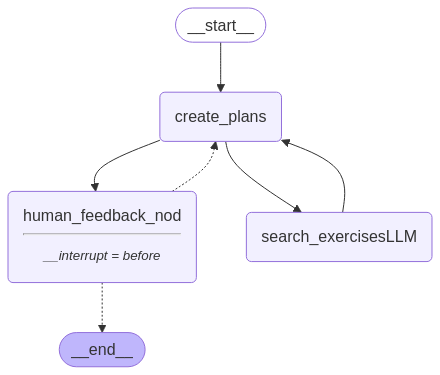

In [93]:
def human_feedback_nod(state: agent_state):
    """ No-op node that should be interrupted on """
    pass
def search_exercisesLLM(state: agent_state):
    """where to search for exercises"""
    pass

def should_continue(state: agent_state):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_feedback', None)
    if human_analyst_feedback:
        return "create_plans"
    
    # Otherwise end
    return END

# Add nodes and edges 
builder = StateGraph(agent_state)
builder.add_node("create_plans", create_plans_for_back)
builder.add_node("human_feedback_nod", human_feedback_nod)
builder.add_node("search_exercisesLLM", search_exercisesLLM)

builder.add_edge(START, "create_plans")
builder.add_edge("create_plans", "search_exercisesLLM")
builder.add_edge("search_exercisesLLM", "create_plans")
builder.add_edge("create_plans", "human_feedback_nod")
builder.add_conditional_edges("human_feedback_nod", should_continue, ["create_plans", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback_nod'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [86]:
# First create an instance with required fields
state = agent_state(
    body_part_exercies=[],  # Your list of single_body_part objects
    Goal="Build muscle",
    intensity="High",
    tall=180,
    weight=75,
    human_feedback="More focus on legs please",
    the_level_of_cardio="Moderate"
)

# Then access the summary property
print(state.summary)

Goal: Build muscle, Intensity: High, Height: 180 cm, Weight: 75 kg, Cardio Level: Moderate, Body Parts: No body parts, Human Feedback: More focus on legs please


In [87]:
# Input
Goal = "lose weight"
intensity= "high"
tall=178
weight=60
body_exercises = []
human_feedback = ""
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(state, thread, stream_mode="values"):
    # Review
    muscle_workouts = event.get('muscle_workouts', '')
    if muscle_workouts:
        for set in muscle_workouts:
            print(set)

i am here at create_plans


ValidationError: 1 validation error for agent_state
body_part_exercies.0
  Input should be a valid dictionary or instance of single_body_part [type=model_type, input_value=('muscle_workouts', [sing...ace for 30 minutes')])]), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.9/v/model_type

In [ ]:
state = graph.get_state(thread)
print(state)

StateSnapshot(values={'goal': 'lose weight', 'max_sub_muscles': 1, 'tall': 178, 'weight': 60, 'muscle_workouts': Perspectives(muscle_workouts=[{'main_muscle': 'Chest', 'sub_muscle': ['Pectoralis major'], 'level_of_cardio': 'moderate'}, {'main_muscle': 'Back', 'sub_muscle': ['Trapezius'], 'level_of_cardio': 'moderate'}, {'main_muscle': 'Shoulders', 'sub_muscle': ['Deltoids'], 'level_of_cardio': 'moderate'}, {'main_muscle': 'Biceps', 'sub_muscle': ['Biceps brachii'], 'level_of_cardio': 'low'}, {'main_muscle': 'Triceps', 'sub_muscle': ['Triceps brachii'], 'level_of_cardio': 'low'}, {'main_muscle': 'Legs', 'sub_muscle': ['Quadriceps'], 'level_of_cardio': 'high'}, {'main_muscle': 'Core', 'sub_muscle': ['Abdominals'], 'level_of_cardio': 'low'}])}, next=('human_feedback_nod',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efbab80-e052-6cf3-8001-7a810a0b8450'}}, metadata={'source': 'loop', 'writes': {'create_plans': {'muscle_workouts': Perspectives(muscle_

In [ ]:
def search_exercises(state):
    """Search for exercises for the sub-muscle groups."""
    # Extract muscle workouts list from state or default to an empty list
    muscle_workouts = state.get("muscle_workouts", [])
    muscle_workouts=muscle_workouts.muscle_workouts
    exercises = []
    print("Starting exercise search...")
    #print(muscle_workouts.muscle_workouts[0]["sub_muscle"][0])

    # Iterate through the list of muscle workout dictionaries
    for muscle in muscle_workouts: 
        main_muscle = muscle["main_muscle"] # Fetch main muscle
        sub_muscle_list = muscle.get("sub_muscle", [])  # Fetch list of sub-muscles
        
        print(f"Main Muscle: {main_muscle}, Sub-Muscles: {sub_muscle_list}")
        
        # Iterate over the sub-muscles and fetch exercises
        for sub_muscle in sub_muscle_list:
            print(f"Fetching exercises for Main Muscle: {main_muscle}, Sub-Muscle: {sub_muscle}")
            
            # Use the tool to fetch exercises
            results = search_exercises_sqlite(main_muscle,  sub_muscle)
            
            if results:
                exercises.append({
                    "main_muscle": main_muscle,
                    "sub_muscle": sub_muscle,
                    "exercises": results
                })
            else:
                print(f"No exercises found for Sub-Muscle: {sub_muscle}")

    print("Exercise search complete.")
    return {"exercises": exercises}


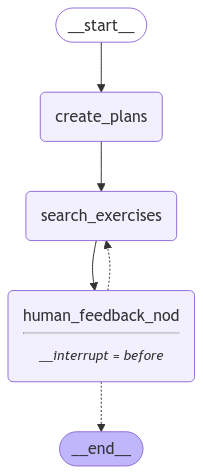

In [ ]:

# Add a new graph
builder2 = StateGraph(Generate__main_muscle)

# Nodes
builder2.add_node("create_plans", create_plans)
builder2.add_node("search_exercises", search_exercises)
builder2.add_node("human_feedback_nod", human_feedback_nod)

# Edges
builder2.add_edge(START, "create_plans")
builder2.add_edge("create_plans", "search_exercises")
builder2.add_edge("search_exercises", "human_feedback_nod")
builder2.add_conditional_edges("human_feedback_nod", should_continue, ["search_exercises", END])

# Compile and visualize
graph2 = builder2.compile(interrupt_before=['human_feedback_nod'], checkpointer=memory)
display(Image(graph2.get_graph(xray=1).draw_mermaid_png()))


In [ ]:
# Input
max_sub_muscles = 1
Goal = "lose weight"
intensity= "high"
tall=178
weight=60
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph2.stream({"Goal":Goal,"max_sub_muscles":max_sub_muscles,"instensity":intensity,"tall":tall,"weight":weight}, thread, stream_mode="values"):
    # Review
    exercises = event.get('exercises', '')
    if exercises:
        for set in exercises:
            print(set)

{'main_muscle': 'Chest', 'sub_muscle': 'Pectoralis Major', 'exercises': [[18, 'Flat Barbell Bench Press', '4 sets', '8-12 reps', 'Middle chest (pectoralis major)', 'Builds overall chest size and strength.', 'Chest'], [19, 'Incline Barbell Bench Press', '3 sets', '8-12 reps', 'Upper chest (clavicular head of pectoralis major)', 'Focuses on the upper part of the chest.', 'Chest'], [20, 'Decline Barbell Bench Press', '3 sets', '8-12 reps', 'Lower chest', 'Adds definition to the lower chest.', 'Chest'], [21, 'Flat Dumbbell Press', '4 sets', '8-12 reps', 'Middle chest', 'Enhances range of motion and muscle activation.', 'Chest'], [22, 'Incline Dumbbell Press', '3 sets', '8-12 reps', 'Upper chest', 'Builds mass and definition in the upper chest.', 'Chest'], [23, 'Chest Fly (Machine)', '3 sets', '8-12 reps', 'Inner chest', 'Isolates the chest and enhances the inner portion.', 'Chest'], [24, 'Cable Crossover (High to Low)', '3 sets', '8-12 reps', 'Lower chest', 'Adds definition and stretch to 

In [ ]:
state = graph2.get_state(thread)
print(state)

StateSnapshot(values={'goal': 'lose weight', 'max_sub_muscles': 1, 'tall': 178, 'weight': 60, 'muscle_workouts': Perspectives(muscle_workouts=[{'main_muscle': 'Chest', 'sub_muscle': ['Pectoralis major'], 'level_of_cardio': 'moderate'}, {'main_muscle': 'Back', 'sub_muscle': ['Trapezius'], 'level_of_cardio': 'moderate'}, {'main_muscle': 'Shoulders', 'sub_muscle': ['Deltoids'], 'level_of_cardio': 'moderate'}, {'main_muscle': 'Biceps', 'sub_muscle': ['Biceps brachii'], 'level_of_cardio': 'low'}, {'main_muscle': 'Triceps', 'sub_muscle': ['Triceps brachii'], 'level_of_cardio': 'low'}, {'main_muscle': 'Legs', 'sub_muscle': ['Quadriceps'], 'level_of_cardio': 'high'}, {'main_muscle': 'Core', 'sub_muscle': ['Abdominals'], 'level_of_cardio': 'low'}]), 'exercises': [{'main_muscle': 'Chest', 'sub_muscle': 'Pectoralis major', 'exercises': [[18, 'Flat Barbell Bench Press', '4 sets', '8-12 reps', 'Middle chest (pectoralis major)', 'Builds overall chest size and strength.', 'Chest'], [19, 'Incline Barb